In [1]:
#%load_ext autoreload
#%autoreload 2
from __future__ import division, print_function
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import OoT.oot as oot
import scipy.misc as sMisc
from astropy.stats import LombScargle
import pylanet.data as pydata
import pylanet.model as pymodel
import pylanet.plot as pyplot
import astropy.units as u
%matplotlib inline

In [2]:
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=3
mpl.rcParams['font.size']=16
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.major.size'] = 3.6
mpl.rcParams['ytick.major.size'] = 3.6
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'

In [3]:
kep2=pydata.getData(2.01,'./data/',cadence='long')
kep13=pydata.getData(13.01,'./data/',cadence='long')

Target: KIC 10666592.
67 data files.
cadence is long
period is 2.204735417
Target: KIC 9941662.
56 data files.
cadence is long
period is 1.763587535


In [4]:
rawTs=kep2.times
rawFs=kep2.sap_fluxs
rawEs=kep2.sap_flux_errs
period=kep2.period

In [5]:
cTs,cFs,cEs=pydata.cleanData(rawTs,rawFs,rawEs,period,nMin=512,detrendMethod='box')
print(cTs.size,' data points')

56109  data points


In [6]:
ts,fs,es=pydata.stackData(cTs,cFs,cEs,period,nTs=128)

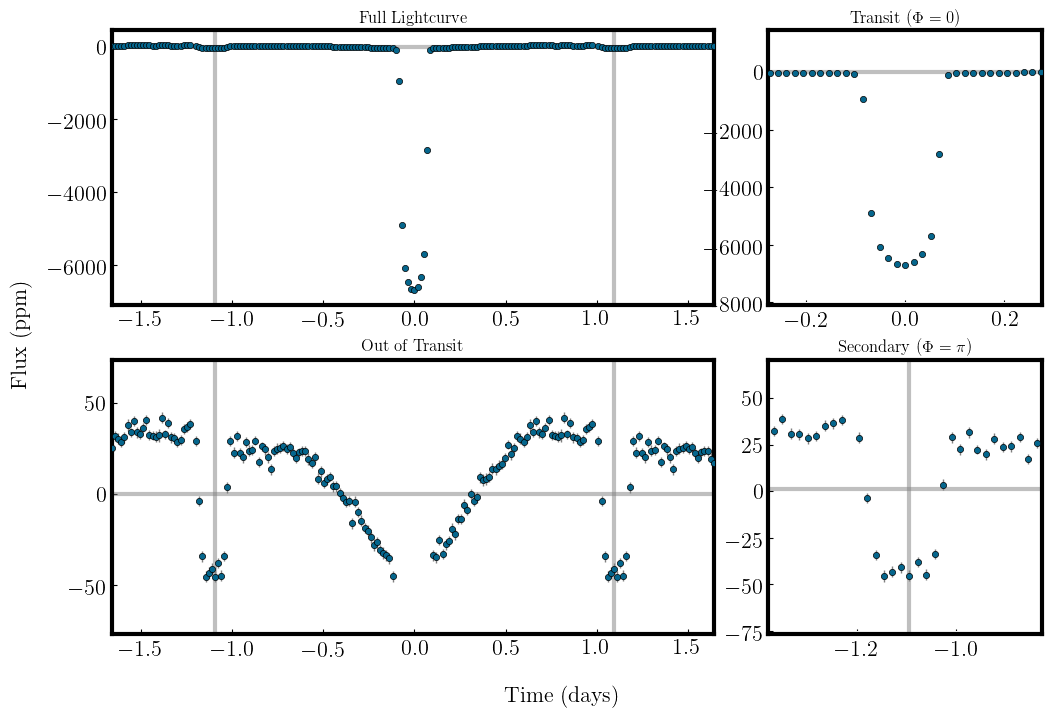

In [7]:
thisFig,thisGrid=pyplot.makeFig()
pyplot.plotData(thisGrid,ts,fs,es,period=period)

In [8]:
import emcee
import batman

planet=oot.planet()
planet.M=1.56
planet.R=2.0
planet.Mp=0.002
planet.Rp=0.155

planet.e=0.006
planet.Ag=0.2
planet.a=planet.a*np.power(period/oot.findPeriod(planet),2/3)
print('a: ',planet.a)
tTransit=0
planet.vPhi=0.5*np.pi
planet.vTheta=83*np.pi/180
planet.tp=planet.tp+(tTransit-oot.findTransit(planet))

nTs=600
modelTs=np.linspace(-period/2,period/2,nTs)
modelFs=1+oot.deltaSum(modelTs,planet)

transit=1
if transit==1:
    t0,per,rp,a,inc,ecc,w=oot.batman(planet)
    params = batman.TransitParams()
    params.t0 = t0                       #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                     #planet radius (in units of stellar radii)
    params.a = a                       #semi-major axis (in units of stellar radii)
    params.inc = inc                     #orbital inclination (in degrees)
    params.ecc = ecc                      #eccentricity
    params.w = w                       #longitude of periastron (in degrees)
    params.u = [0.6]                #limb darkening coefficients
    params.limb_dark = "linear"       #limb darkening model

    m = batman.TransitModel(params, modelTs)
    batmanModel=m.light_curve(params)
    modelFs=modelFs*batmanModel
norm=np.median(modelFs)
modelFs=(modelFs/norm)-1
    #fs=deltas-np.max(deltas)
modelEs=0.1*np.ones_like(modelFs)*np.median(np.abs(modelFs))


a:  8.271231707463656


/Users/Emily/Documents/Columbia/heartbeatPlanets/OoT/oot.py:142: RuntimeWarning: invalid value encountered in arccos
  firstTerm=((rUnit*pl.Rp)**2)*np.arccos((d**2 + (rUnit*pl.Rp)**2 - pl.R**2)/(2*d*(rUnit*pl.Rp)))
/Users/Emily/Documents/Columbia/heartbeatPlanets/OoT/oot.py:143: RuntimeWarning: invalid value encountered in arccos
  secondTerm=(pl.R**2)*np.arccos((d**2 + pl.R**2 - (rUnit*pl.Rp)**2)/(2*d*pl.R))
/Users/Emily/Documents/Columbia/heartbeatPlanets/OoT/oot.py:144: RuntimeWarning: invalid value encountered in sqrt
  thirdTerm=-0.5*np.sqrt((d+(rUnit*pl.Rp)+pl.R)*(d+(rUnit*pl.Rp)-pl.R)*(d+pl.R-(rUnit*pl.Rp))*(-d+pl.R+(rUnit*pl.Rp)))


/Users/Emily/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


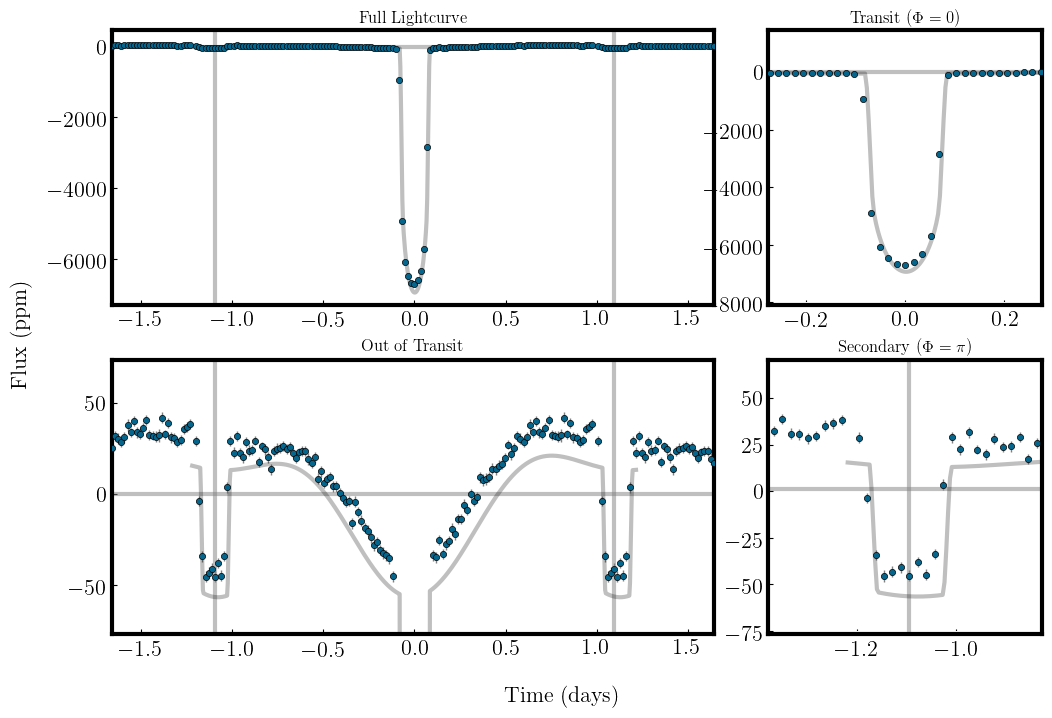

In [9]:
thisFig,thisGrid=pyplot.makeFig()
pyplot.plotData(thisGrid,ts,fs,es,period=period)
pyplot.plotModel(thisGrid,modelTs,modelFs,period=period)

In [10]:
def translateParams(planet,x):
    planet.M=10**x[0]
    planet.Mp=10**x[1]
    planet.R=10**x[2]
    planet.Rp=10**x[3]
    planet.e=10**x[4]
    planet.Ag=x[5]
    tTransit=x[6]

    #planet.tp=tTransit-oot.findTransit(planet)
    planet.a=planet.a*np.power(period/oot.findPeriod(planet),2/3) # For a known period, a is a dependant variable
    
    b=x[7]
    planet.vTheta=np.arccos(b*planet.R/planet.a)
    planet.vPhi=x[8]
    
    planet.tp=planet.tp+(tTransit-oot.findTransit(planet))
    
    return planet

def mapXs(x): #maps 0->1 to appropriate parameter values
    newX=np.copy(x)
    if len(newX.shape)==1:
        newX=newX[np.newaxis,:]
    newX[:,0]=-1+2*newX[:,0] #log(M)
    newX[:,1]=-3.5+3*newX[:,1] #log(Mp)
    newX[:,2]=-1.5+3*newX[:,2] #log(R)
    newX[:,3]=-2+2*newX[:,3] #log(Rp)
    newX[:,4]=-3+3*newX[:,4] #log(e)
    newX[:,5]=0.5*newX[:,5] #Ag
    newX[:,6]=(-0.5+newX[:,6])*period # tTransit
    newX[:,7]=newX[:,7] # b
    newX[:,8]=2*np.pi*newX[:,8] # vPhi
    newX[:,9]=(-0.5+newX[:,9])*2e-4 # offset
    if len(x.shape)==1:
        return newX[0,:]
    return newX

def priors(x):
    if (np.min(x)<0) | (np.max(x)>1):
        return -np.inf
    else:
        return 0.0
    
def lnprob(x,ts,fs,es,planet):
    """The log-likelihood function."""
    prior=priors(x) # all x between 0 and 1
    if prior<0:
        return prior
    x=mapXs(x) # maps them to appropriate parameter values
    planet=translateParams(planet,x)
    if (planet.R<planet.Rp) | (planet.R>planet.a):
        return -np.inf #at the moment oot breaks if R<Rp - should investigate
    
    ootFs=1+oot.deltaSum(ts,planet,secondary=1)
    
    transit=oot.checkTransit(planet)
    if transit==1:
        t0,per,rp,a,inc,ecc,w=oot.batman(planet)
        params = batman.TransitParams()
        params.t0 = t0                       #time of inferior conjunction
        params.per = per                      #orbital period
        params.rp = rp                     #planet radius (in units of stellar radii)
        params.a = a                       #semi-major axis (in units of stellar radii)
        params.inc = inc                     #orbital inclination (in degrees)
        params.ecc = ecc                      #eccentricity
        params.w = w                       #longitude of periastron (in degrees)
        params.u = [0.6]                #limb darkening coefficients
        params.limb_dark = "linear"       #limb darkening model

        m = batman.TransitModel(params, ts)
        batmanModel=m.light_curve(params)
        modelFs=ootFs*batmanModel
    else:
        modelFs=ootFs
    
    norm=np.median(modelFs)
    deltas=(modelFs/norm)-1
    deltas=deltas+x[9]
    #deltas=deltas-np.max(deltas)
    
    residual=np.power((deltas-fs)/es,2)
    return -(np.sum(residual)/2) + prior

ndim, nwalkers = 10, 128
p0=np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

nSteps = 1024
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,args=[ts,fs,es,planet])
pos, prob, state=sampler.run_mcmc(p0,nSteps)

/Users/Emily/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in arccos
/Users/Emily/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/Emily/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


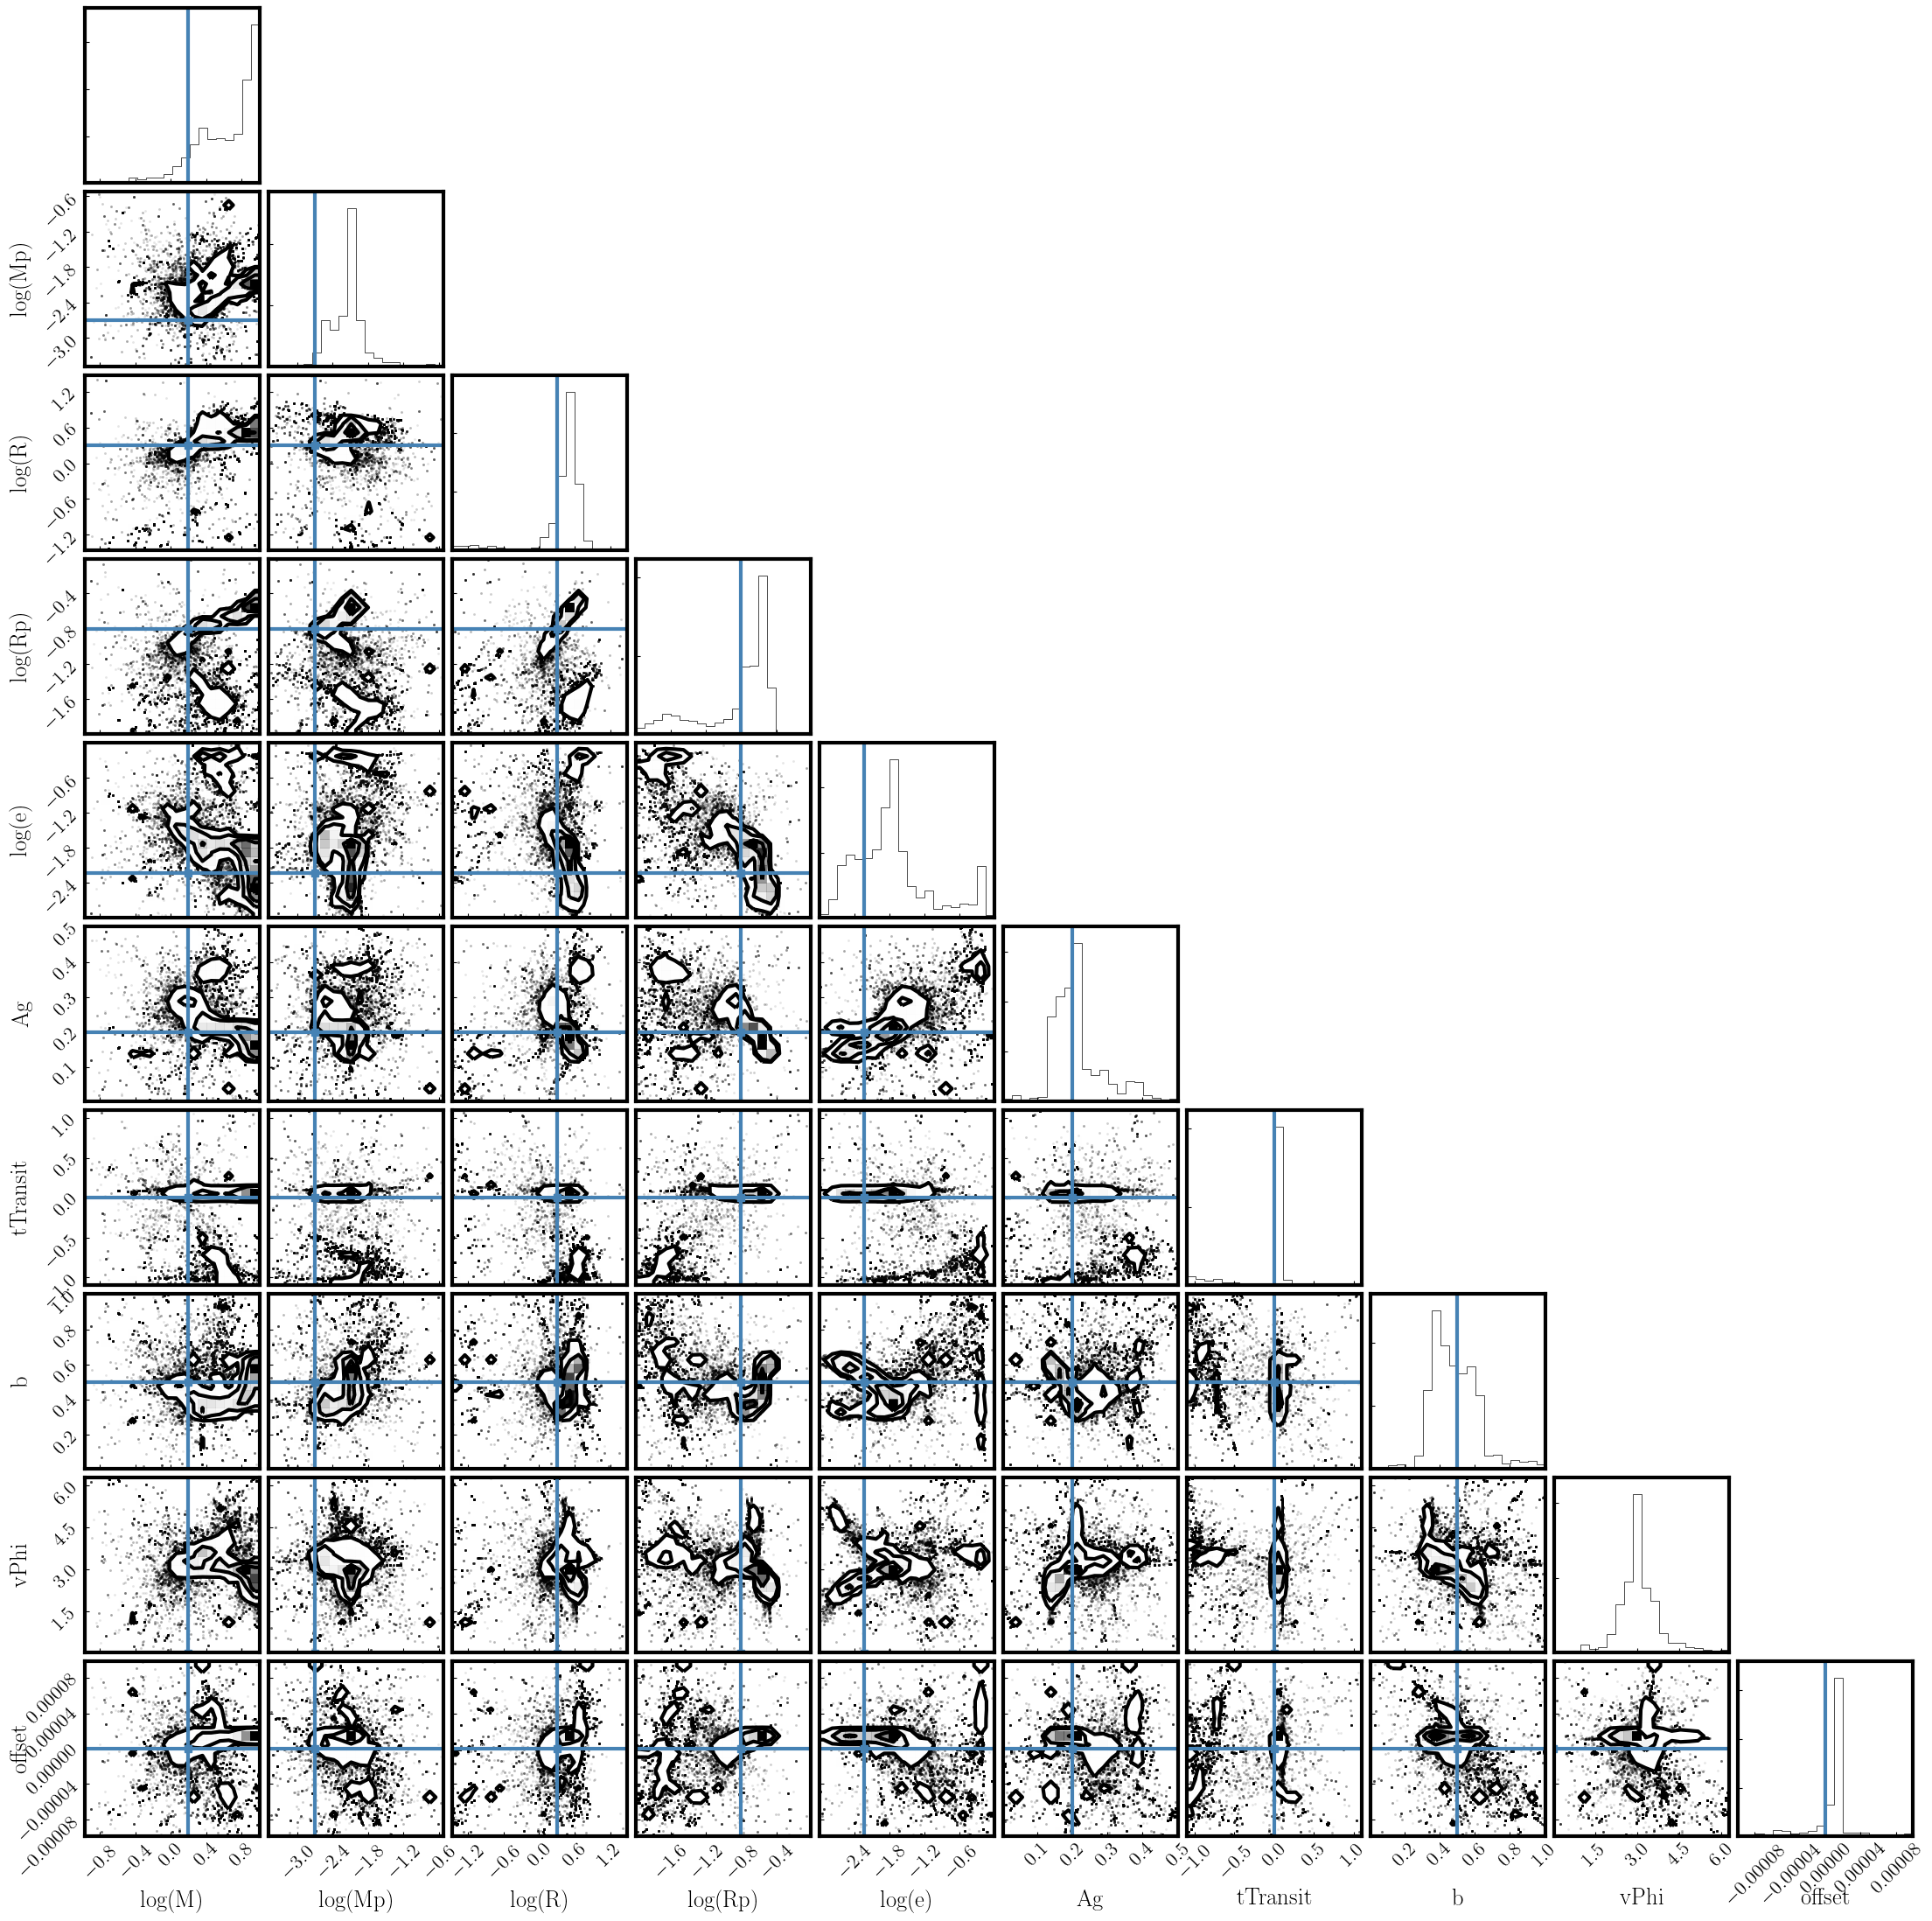

In [11]:
import corner
samples = sampler.chain.reshape((-1, ndim))
truths=[np.log10(1.56),np.log10(0.002),np.log10(2),np.log10(0.155),np.log10(0.006),0.2,0,0.5,0,0]
mapped=mapXs(samples)
fig = corner.corner(mapped,labels=['log(M)','log(Mp)','log(R)','log(Rp)','log(e)','Ag','tTransit','b','vPhi','offset'],truths=truths)
plt.show()

In [12]:
bestX=pos[np.argmax(prob),:]
print(mapXs(bestX))
planet=translateParams(planet,mapXs(bestX))
planet.a=planet.a*np.power(period/oot.findPeriod(planet),2/3)

nTs=600
modelTs=np.linspace(-period/2,period/2,nTs)
#modelTs=np.hstack([modelTs[:500],modelTs[600:]])
ootFs=1+oot.deltaSum(modelTs,planet)#,secondary=1)

transit=oot.checkTransit(planet)
if transit==1:
    t0,per,rp,a,inc,ecc,w=oot.batman(planet)
    params = batman.TransitParams()
    params.t0 = t0                       #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                     #planet radius (in units of stellar radii)
    params.a = a                       #semi-major axis (in units of stellar radii)
    params.inc = inc                     #orbital inclination (in degrees)
    params.ecc = ecc                      #eccentricity
    params.w = w                       #longitude of periastron (in degrees)
    params.u = [0.6]                #limb darkening coefficients
    params.limb_dark = "linear"       #limb darkening model

    m = batman.TransitModel(params, modelTs)
    batmanModel=m.light_curve(params)
    modelFs=ootFs*batmanModel
    norm=np.median(modelFs)
    
deltas=(modelFs/norm)-1
deltas=deltas+mapXs(bestX)[9]
#deltas=deltas-np.max(deltas)

[ 9.37792836e-01 -2.18730170e+00  6.15716321e-01 -4.86492595e-01
 -2.78909940e+00  1.32747624e-01  9.83774510e-02  6.47408476e-01
  1.37267943e+00  1.10225606e-05]


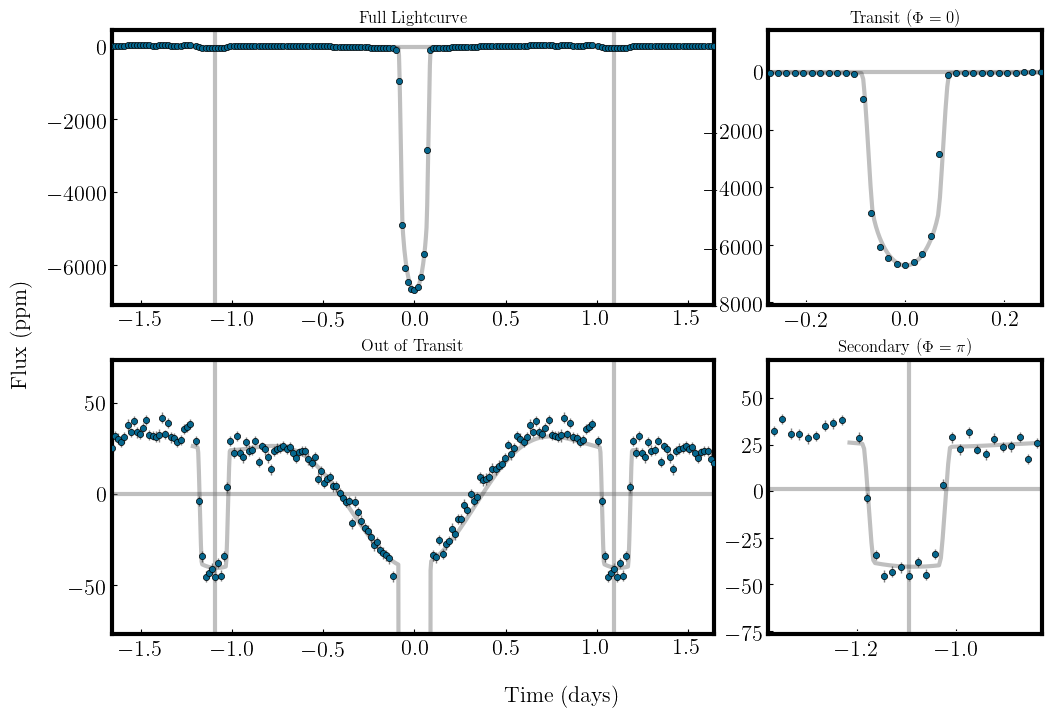

In [13]:
thisFig,thisGrid=pyplot.makeFig()
pyplot.plotData(thisGrid,ts,fs,es,period=kep2.period)
pyplot.plotModel(thisGrid,modelTs,deltas,period=kep2.period)
plt.show()

a:  8.271231707463656
51
32


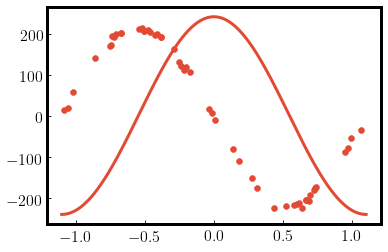

In [135]:
import astropy.io
planet=oot.planet()
planet.M=1.56
planet.R=2.0
planet.Mp=0.002
planet.Rp=0.155

planet.e=0.006
planet.Ag=0.2
planet.a=planet.a*np.power(period/oot.findPeriod(planet),2/3)
print('a: ',planet.a)
tTransit=0
planet.vPhi=0.5*np.pi
planet.vTheta=83*np.pi/180

data=astropy.io.ascii.read('hat-p-7b.csv')
rTs=data['x']*period # in days
rVs=data['rvs'] # in ms-1
rEs=np.array([5,15,15,15,8,10,15,12,5,5,10,12,10,10,15,15,8,5,5,5,10,12,12,5,5,15,10,8,15,20,5,10])
print(rVs.size)
print(rEs.size)
thisPlot=plt.gca()
thisPlot.scatter(rTs,rVs)
modelRvs=oot.vOrbit(modelTs,planet)#*695508000/(24*60*2)
thisPlot.plot(modelTs,modelRvs)
plt.show()

In [155]:
def rvParams(planet,x):
    planet.M=10**x[0]
    planet.Mp=10**x[1]
    planet.R=10**x[2]
    planet.e=10**x[3]
    tTransit=x[4]

    #planet.tp=tTransit-oot.findTransit(planet)
    planet.a=planet.a*np.power(period/oot.findPeriod(planet),2/3) # For a known period, a is a dependant variable
    
    b=x[5]
    planet.vTheta=np.arccos(b*planet.R/planet.a)
    planet.vPhi=x[6]
    
    planet.tp=planet.tp+(tTransit-oot.findTransit(planet))
    return planet

def mapRvs(x): #maps 0->1 to appropriate parameter values
    newX=np.copy(x)
    if len(newX.shape)==1:
        newX=newX[np.newaxis,:]
    newX[:,0]=-1+2*newX[:,0] #log(M)
    newX[:,1]=-3.5+3*newX[:,1] #log(Mp)
    newX[:,2]=-1.5+3*newX[:,2] #log(R)
    newX[:,3]=-3+3*newX[:,3] #log(e)
    newX[:,4]=(-0.5+newX[:,4])*period # tTransit
    newX[:,5]=newX[:,5] # b
    newX[:,6]=2*np.pi*newX[:,6] # vPhi
    if len(x.shape)==1:
        return newX[0,:]
    return newX

def priors(x):
    if (np.min(x)<0) | (np.max(x)>1):
        return -np.inf
    else:
        return 0.0
    
def rvprob(x,ts,rvs,rEs,planet):
    """The log-likelihood function."""
    prior=priors(x) # all x between 0 and 1
    if prior<0:
        return prior
    x=mapRvs(x) # maps them to appropriate parameter values
    planet=rvParams(planet,x)
    if (planet.R>planet.a):
        return -np.inf #at the moment oot breaks if R<Rp - should investigate
    
    ootRvs=oot.vSum(ts,planet)
    
    residual=np.power((ootRvs-rvs)/rEs,2)
    return -(np.sum(residual)/2) + prior

ndim, nwalkers = 7, 64
p0=np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

nSteps = 512
sampler = emcee.EnsembleSampler(nwalkers, ndim, rvprob,args=[rTs,rVs,10*np.ones_like(rVs),planet])
pos, prob, state=sampler.run_mcmc(p0,nSteps)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in arccos
  if sys.path[0] == '':


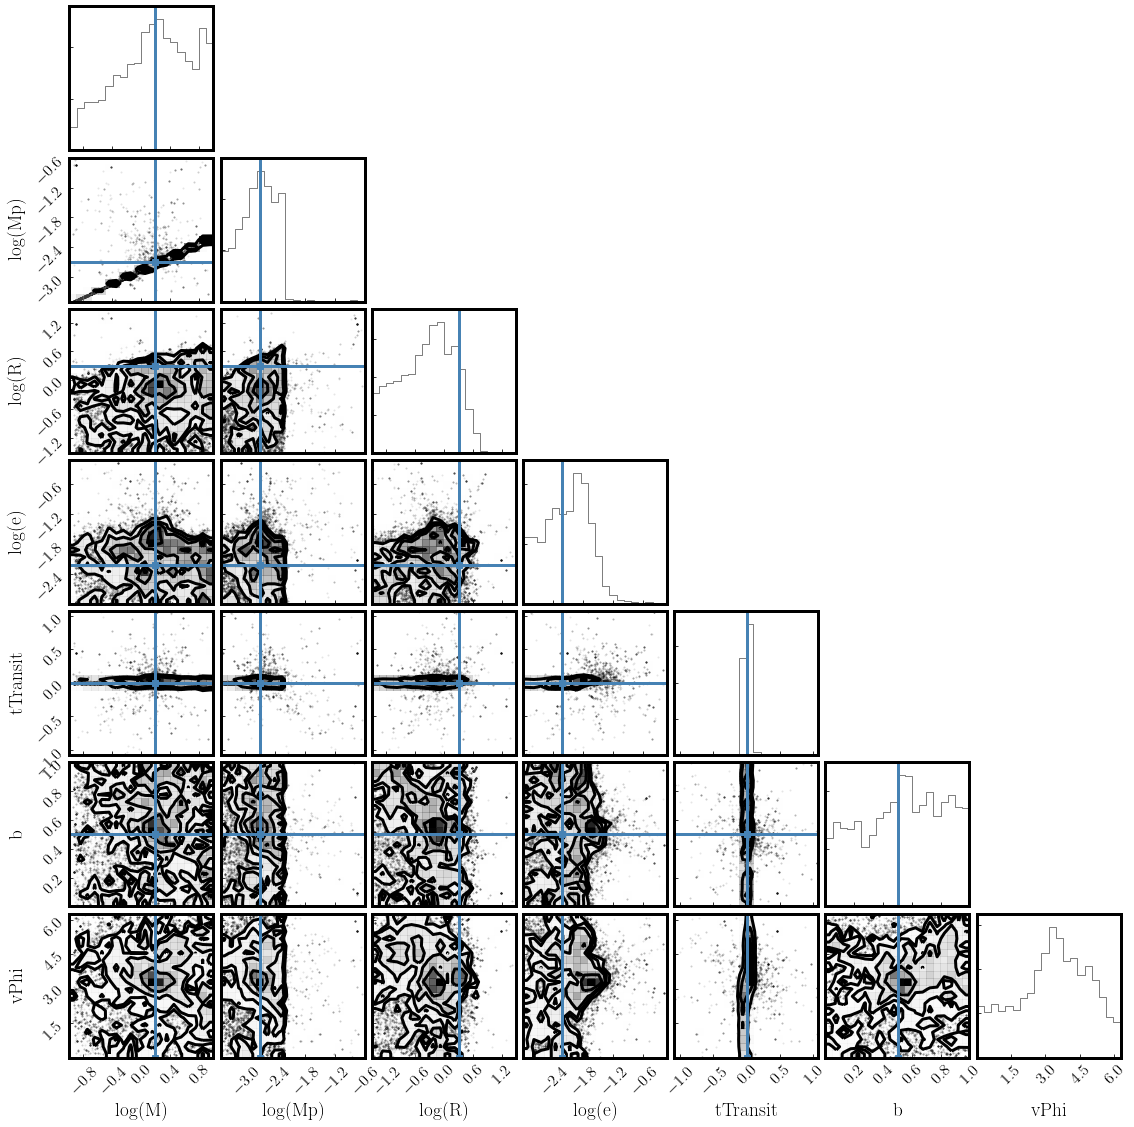

In [156]:
samples = sampler.chain.reshape((-1, ndim))
truths=[np.log10(1.56),np.log10(0.002),np.log10(2),np.log10(0.006),0,0.5,0,0]
mapped=mapRvs(samples)
fig = corner.corner(mapped,labels=['log(M)','log(Mp)','log(R)','log(e)','tTransit','b','vPhi','offset'],truths=truths)
plt.show()

[-2.41107270e-01 -3.04015232e+00 -7.05149062e-01 -1.98269213e+00
  1.40258935e-03  1.28514273e-02  5.38328463e+00]


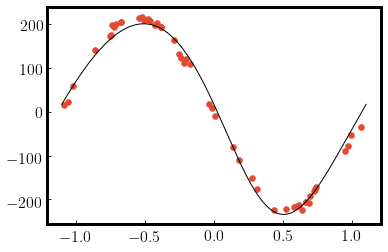

In [157]:
bestX=pos[np.argmax(prob),:]
print(mapRvs(bestX))
planet=rvParams(planet,mapRvs(bestX))
planet.a=planet.a*np.power(period/oot.findPeriod(planet),2/3)
planet.e=0.1
nTs=600
modelTs=np.linspace(-period/2,period/2,nTs)

thisPlot=plt.gca()
thisPlot.scatter(rTs,rVs)
modelRvs=oot.vSum(modelTs,planet)#*695508000/(24*60*2)
thisPlot.plot(modelTs,modelRvs,c='k',lw=1)
plt.show()

In [146]:
def translateParams(planet,x):
    planet.M=10**x[0]
    planet.Mp=10**x[1]
    planet.R=10**x[2]
    planet.Rp=10**x[3]
    planet.e=10**x[4]
    planet.Ag=x[5]
    tTransit=x[6]

    #planet.tp=tTransit-oot.findTransit(planet)
    planet.a=planet.a*np.power(period/oot.findPeriod(planet),2/3) # For a known period, a is a dependant variable
    #print(planet.a)
    
    b=x[7]
    planet.vTheta=np.arccos(b*planet.R/planet.a)
    planet.vPhi=x[8]
    
    planet.tp=planet.tp+(tTransit-oot.findTransit(planet))
    
    return planet

def mapXs(x): #maps 0->1 to appropriate parameter values
    newX=np.copy(x)
    if len(newX.shape)==1:
        newX=newX[np.newaxis,:]
    newX[:,0]=-1+2*newX[:,0] #log(M)
    newX[:,1]=-3.5+3*newX[:,1] #log(Mp)
    newX[:,2]=-1.5+3*newX[:,2] #log(R)
    newX[:,3]=-2+2*newX[:,3] #log(Rp)
    newX[:,4]=-3+3*newX[:,4] #log(e)
    newX[:,5]=0.5*newX[:,5] #Ag
    newX[:,6]=(-0.5+newX[:,6])*period # tTransit
    newX[:,7]=newX[:,7] # b
    newX[:,8]=2*np.pi*newX[:,8] # vPhi
    newX[:,9]=(-0.5+newX[:,9])*2e-4 # offset
    newX[:,10]=(-0.5+newX[:,10])*period # tRvOffset
    if len(x.shape)==1:
        return newX[0,:]
    return newX

def priors(x):
    if (np.min(x)<0) | (np.max(x)>1):
        return -np.inf
    else:
        return 0.0
    
def lnprob(x,ts,fs,es,rTs,rVs,rEs,planet):
    """The log-likelihood function."""
    prior=priors(x) # all x between 0 and 1
    if prior<0:
        return prior
    x=mapXs(x) # maps them to appropriate parameter values
    planet=translateParams(planet,x)
    if (planet.R<planet.Rp) | (planet.R>planet.a):
        return -np.inf #at the moment oot breaks if R<Rp - should investigate
    
    ootFs=1+oot.deltaSum(ts,planet,secondary=1)
    
    transit=oot.checkTransit(planet)
    if transit==1:
        t0,per,rp,a,inc,ecc,w=oot.batman(planet)
        params = batman.TransitParams()
        params.t0 = t0                       #time of inferior conjunction
        params.per = per                      #orbital period
        params.rp = rp                     #planet radius (in units of stellar radii)
        params.a = a                       #semi-major axis (in units of stellar radii)
        params.inc = inc                     #orbital inclination (in degrees)
        params.ecc = ecc                      #eccentricity
        params.w = w                       #longitude of periastron (in degrees)
        params.u = [0.6]                #limb darkening coefficients
        params.limb_dark = "linear"       #limb darkening model

        m = batman.TransitModel(params, ts)
        batmanModel=m.light_curve(params)
        modelFs=ootFs*batmanModel
    else:
        modelFs=ootFs
    
    norm=np.median(modelFs)
    deltas=(modelFs/norm)-1
    deltas=deltas+x[9]
    #deltas=deltas-np.max(deltas)
    
    residual=np.power((deltas-fs)/es,2)
    
    rvTs=((rTs+x[10])%period)-(period/2)
    ootRvs=oot.vSum(rvTs,planet)
    rvResidual=np.power((ootRvs-rVs)/rEs,2)
    
    return -(np.sum(residual)/2) -(np.sum(rvResidual)/2) + prior

ndim, nwalkers = 11, 128
p0=np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

nSteps = 2048
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,args=[ts,fs,es,rTs,rVs,5*np.ones_like(rVs),planet])
pos, prob, state=sampler.run_mcmc(p0,nSteps)

/Users/zephyrpenoyre/Google Drive/astro/pythonModules/OoT/oot.py:141: RuntimeWarning: invalid value encountered in arccos
  firstTerm=((rUnit*pl.Rp)**2)*np.arccos((d**2 + (rUnit*pl.Rp)**2 - pl.R**2)/(2*d*(rUnit*pl.Rp)))
/Users/zephyrpenoyre/Google Drive/astro/pythonModules/OoT/oot.py:142: RuntimeWarning: invalid value encountered in arccos
  secondTerm=(pl.R**2)*np.arccos((d**2 + pl.R**2 - (rUnit*pl.Rp)**2)/(2*d*pl.R))
/Users/zephyrpenoyre/Google Drive/astro/pythonModules/OoT/oot.py:143: RuntimeWarning: invalid value encountered in sqrt
  thirdTerm=-0.5*np.sqrt((d+(rUnit*pl.Rp)+pl.R)*(d+(rUnit*pl.Rp)-pl.R)*(d+pl.R-(rUnit*pl.Rp))*(-d+pl.R+(rUnit*pl.Rp)))
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in arccos
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/

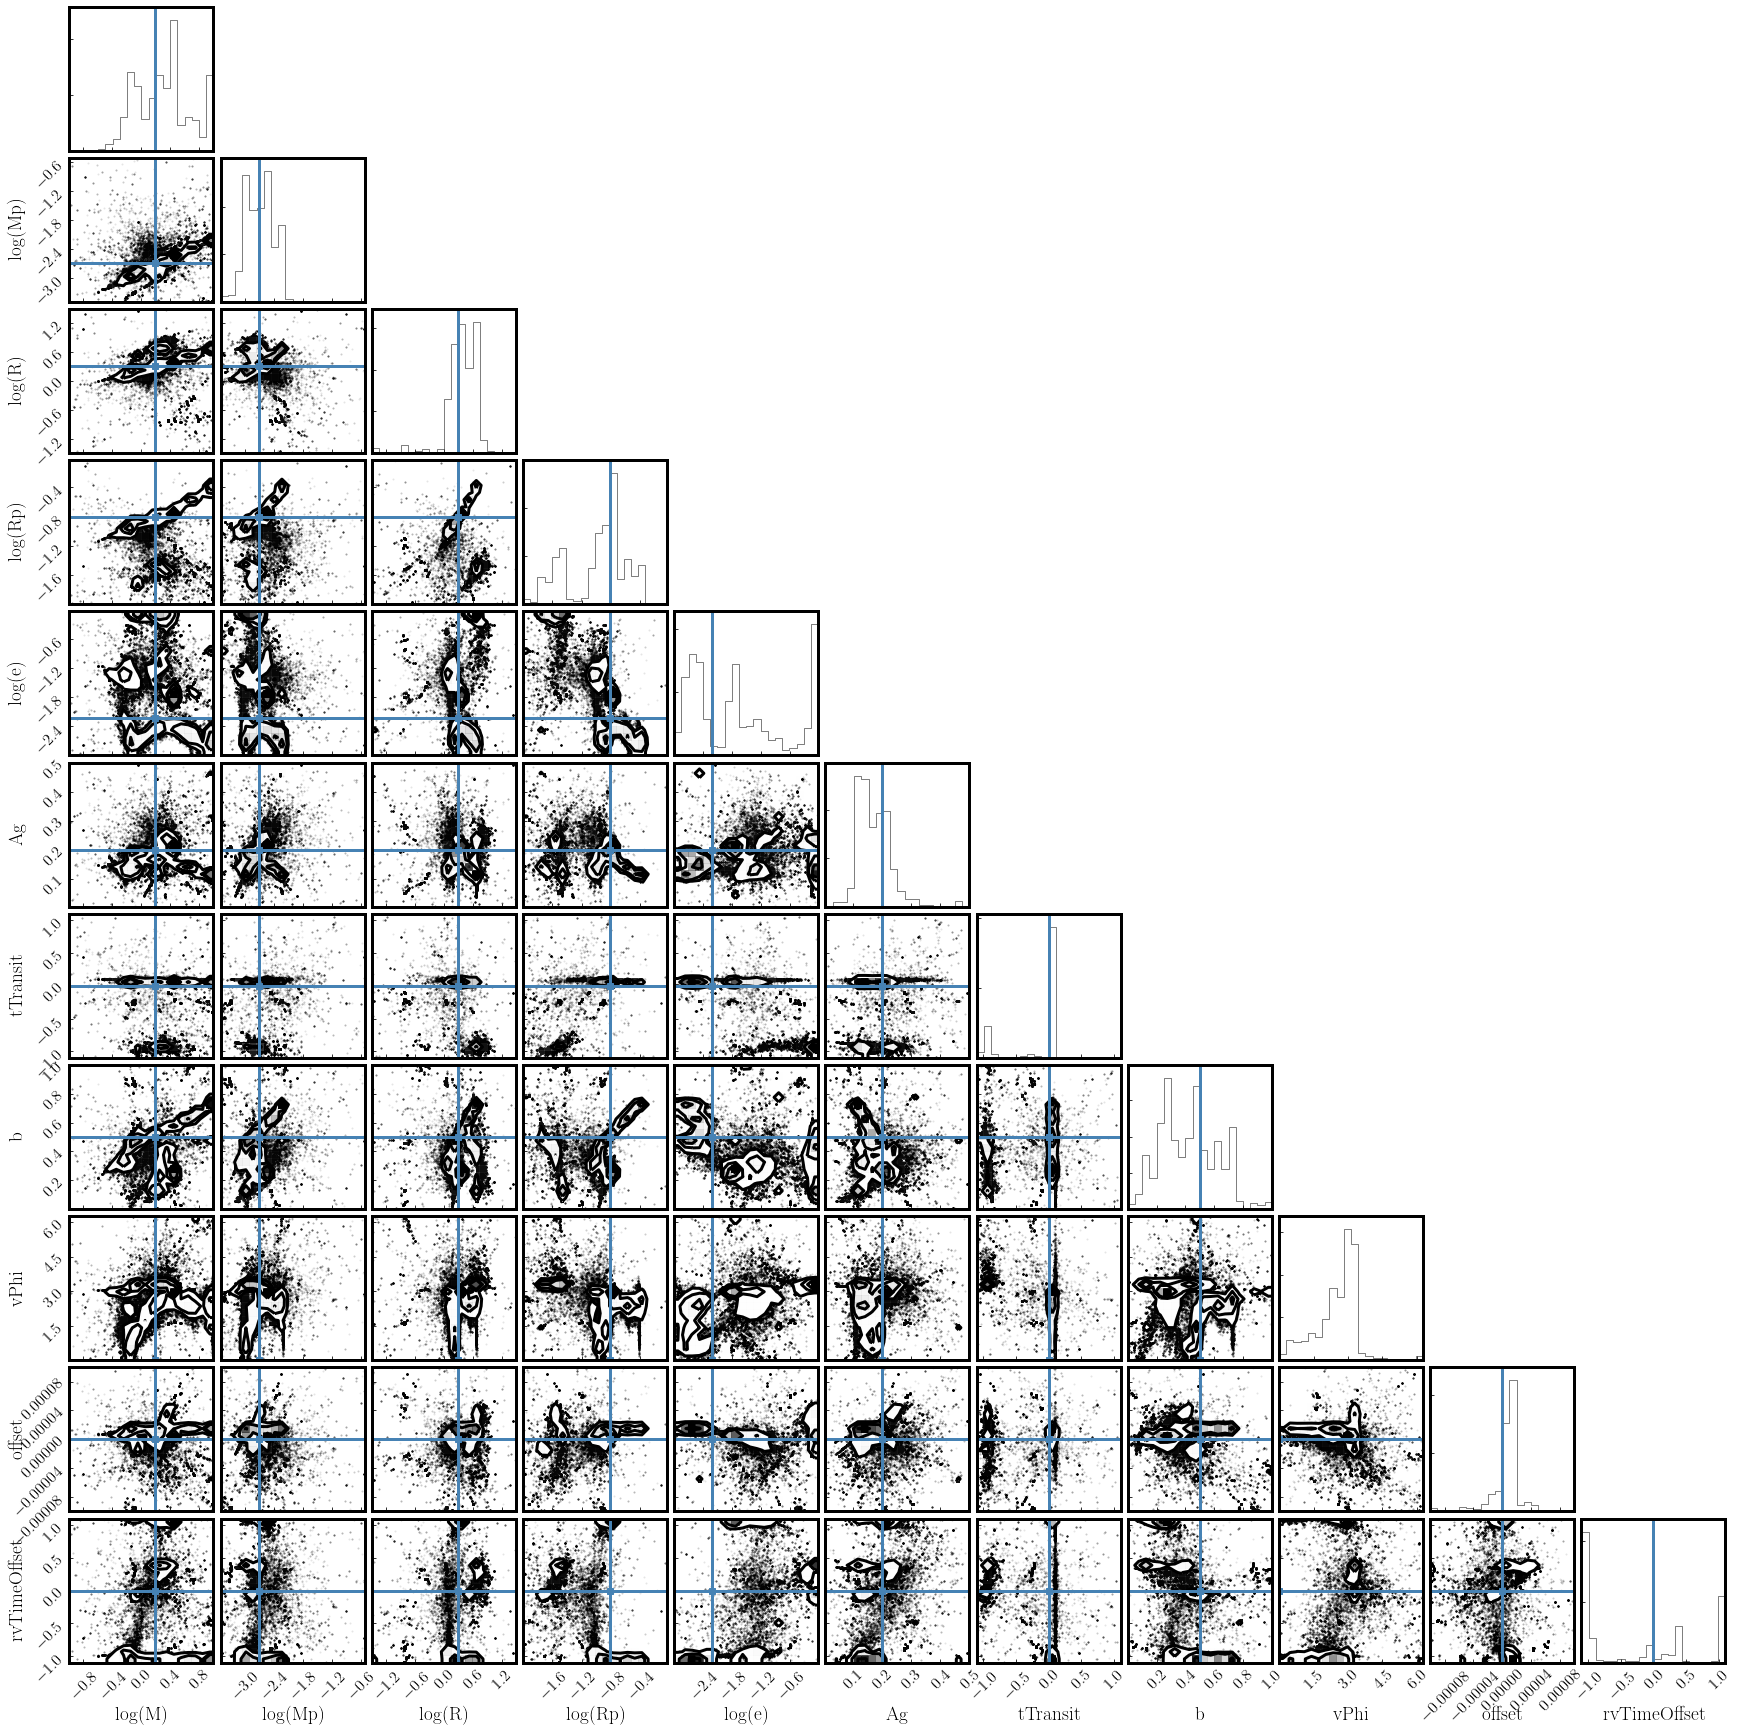

In [147]:
import corner
samples = sampler.chain.reshape((-1, ndim))
truths=[np.log10(1.56),np.log10(0.002),np.log10(2),np.log10(0.155),np.log10(0.006),0.2,0,0.5,0,0,0]
mapped=mapXs(samples)
fig = corner.corner(mapped,labels=['log(M)','log(Mp)','log(R)','log(Rp)','log(e)','Ag','tTransit','b','vPhi','offset','rvTimeOffset'],truths=truths)
plt.show()

[ 9.86397871e-01 -2.21194892e+00  6.74196959e-01 -4.15586693e-01
 -2.58684076e+00  1.05019847e-01  9.88879772e-02  7.28945974e-01
  2.61287313e+00  1.29046085e-05 -9.96221905e-01]


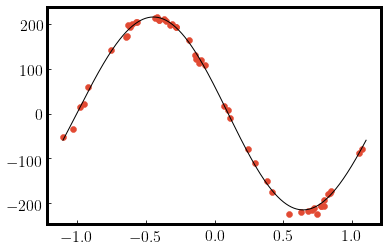

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


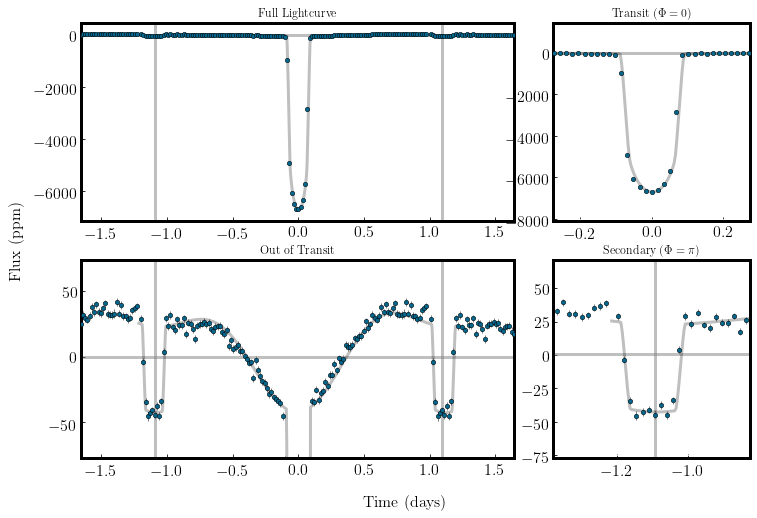

In [148]:
bestX=pos[np.argmax(prob),:]
print(mapXs(bestX))
planet=translateParams(planet,mapXs(bestX))
planet.a=planet.a*np.power(period/oot.findPeriod(planet),2/3)

nTs=600
modelTs=np.linspace(-period/2,period/2,nTs)
rvTs=((rTs+mapXs(bestX)[10])%period)-(period/2)

thisPlot=plt.gca()
thisPlot.scatter(rvTs,rVs)
modelRvs=oot.vSum(modelTs,planet)#*695508000/(24*60*2)
thisPlot.plot(modelTs,modelRvs,c='k',lw=1)
plt.show()

ootFs=1+oot.deltaSum(modelTs,planet)#,secondary=1)

transit=oot.checkTransit(planet)
if transit==1:
    t0,per,rp,a,inc,ecc,w=oot.batman(planet)
    params = batman.TransitParams()
    params.t0 = t0                       #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                     #planet radius (in units of stellar radii)
    params.a = a                       #semi-major axis (in units of stellar radii)
    params.inc = inc                     #orbital inclination (in degrees)
    params.ecc = ecc                      #eccentricity
    params.w = w                       #longitude of periastron (in degrees)
    params.u = [0.6]                #limb darkening coefficients
    params.limb_dark = "linear"       #limb darkening model

    m = batman.TransitModel(params, modelTs)
    batmanModel=m.light_curve(params)
    modelFs=ootFs*batmanModel
    norm=np.median(modelFs)
    
deltas=(modelFs/norm)-1
deltas=deltas+mapXs(bestX)[9]

thisFig,thisGrid=pyplot.makeFig()
pyplot.plotData(thisGrid,ts,fs,es,period=period)
pyplot.plotModel(thisGrid,modelTs,deltas,period=period)
plt.show()

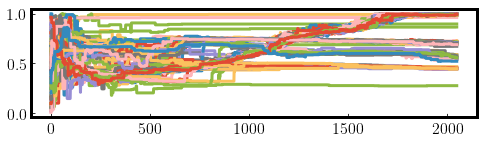

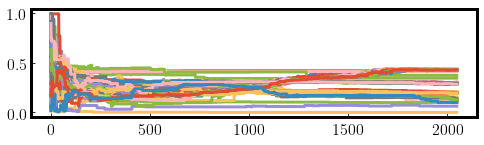

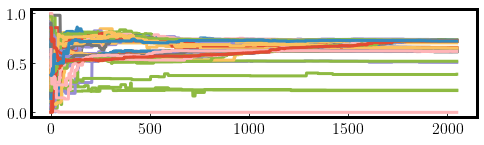

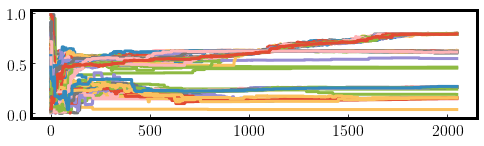

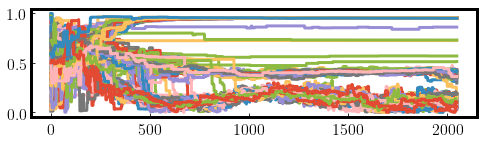

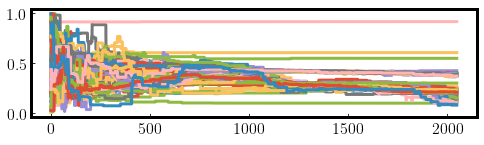

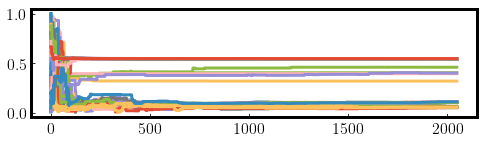

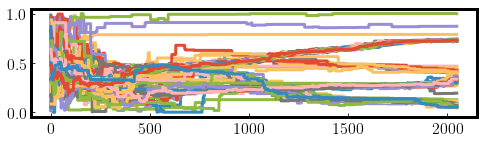

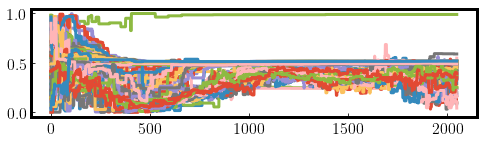

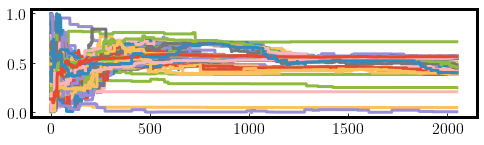

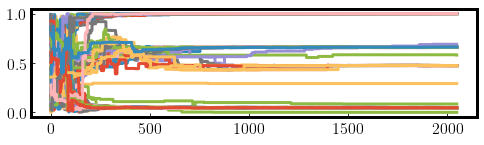

In [150]:
for i in range(11):
    fig = plt.figure(figsize=(8,2))
    for j in range(128):
        plt.plot(sampler.chain[j,:,i])
    plt.show()

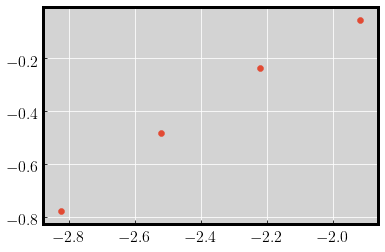

0.7217662010025854
0.9030899869919435


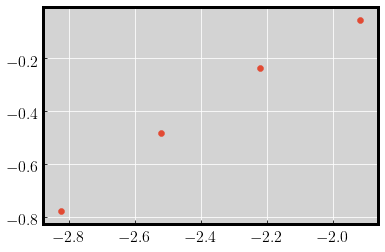

0.5691239332329746
0.7201593034059568


In [169]:
mpl.rcParams['axes.facecolor']='lightgrey'

d1s=np.array([1.5,3,6,12])*1e-3
v1s=np.array([0.167,0.33,0.58,0.88])
onePlot=plt.gca()
onePlot.scatter(np.log10(d1s),np.log10(v1s))
#onePlot.set_xscale('log')
#onePlot.set_yscale('log')
plt.show()
mpl.rcParams['axes.facecolor']='white'
print(np.log10(v1s[-1])-np.log10(v1s[0]))
print(np.log10(d1s[-1])-np.log10(d1s[0]))

mpl.rcParams['axes.facecolor']='lightgrey'

d2s=np.array([10,17.5,30,52.5])*1e-3
v2s=np.array([0.89,1.5,2.65,3.30])
twoPlot=plt.gca()
twoPlot.scatter(np.log10(d1s),np.log10(v1s))
plt.show()
mpl.rcParams['axes.facecolor']='white'
print(np.log10(v2s[-1])-np.log10(v2s[0]))
print(np.log10(d2s[-1])-np.log10(d2s[0]))

1047.3459720045648


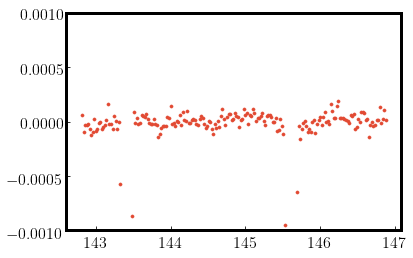

NameError: name 'vsd' is not defined

In [257]:
from astropy.stats import LombScargle

tTransit=cTs[np.argmin(cFs)]
print(tTransit)
windowWidth=np.pi/30
mask=np.flatnonzero((np.abs((cTs-tTransit)%period) > windowWidth*period) & (np.abs((cTs-tTransit)%period) < (1-windowWidth)*period) & \
                    ((np.abs((cTs-tTransit)%period) < (0.5-windowWidth)*period) | (np.abs((cTs-tTransit)%period) > (0.5+windowWidth)*period)))
                    
maskTs=cTs[mask]
maskFs=cFs[mask]
#plt.scatter(cTs[500:600],cFs[500:600])
curvePlot=plt.gca()
#curvePlot.scatter(maskTs[500:600],maskFs[500:600],s=10)
curvePlot.scatter(cTs[500:700],cFs[500:700],s=10)
curvePlot.set_ylim(-1e-3,1e-3)
plt.show()

freq, power = LombScargle(maskTs[500:1000], maskFs[500:1000]).autopower(normalization='psd')
nTimes=ts.size

pPlot=plt.gca()
pPlot.plot(freq*period, 2*1e6*np.sqrt(power)/np.sqrt(nTimes))
pPlot.set_xlim(0,10)
plt.show()

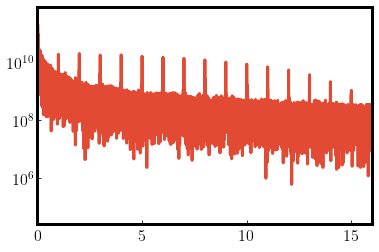

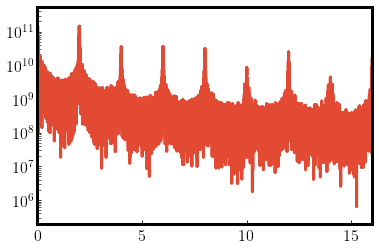

In [263]:
#rTs=np.hstack(rawTs)
#rFs=np.hstack(rawFs)
rTs,rFs,trash=pydata.cleanGaps(rawTs,rawFs,rawEs,nMin=0)
rTs=np.hstack(rTs)
rFs=np.hstack(rFs)

freq, power = LombScargle(rTs, rFs).autopower(normalization='psd')
nTimes=ts.size

pPlot=plt.gca()
pPlot.plot(freq*period, 2*1e6*np.sqrt(power)/np.sqrt(nTimes))
pPlot.set_xlim(0,16)
pPlot.set_yscale('log')
plt.show()

windowWidth=np.pi/30
mask=np.flatnonzero((np.abs((rTs-tTransit)%period) > windowWidth*period) & (np.abs((rTs-tTransit)%period) < (1-windowWidth)*period) & \
                    ((np.abs((rTs-tTransit)%period) < (0.5-windowWidth)*period) | (np.abs((rTs-tTransit)%period) > (0.5+windowWidth)*period)))
                    
maskTs=rTs[mask]
maskFs=rFs[mask]
freq, power = LombScargle(maskTs, maskFs).autopower(normalization='psd')
nTimes=ts.size

pPlot=plt.gca()
pPlot.plot(freq*period, 2*1e6*np.sqrt(power)/np.sqrt(nTimes))
pPlot.set_xlim(0,16)
pPlot.set_yscale('log')
plt.show()

In [256]:
print(rTs[0:10])

[120.53881584 120.55925018 120.57968442 120.60011886 120.6205532
 120.64098744 120.66142178 120.68185622 120.70229046 120.7227248 ]
